In [1]:
# from adsorbate_slab_config_fixed_seed import AdsorbateSlabConfig
from ocdata.core import Adsorbate, Bulk, Slab 
from ocdata.utils import DetectTrajAnomaly
from ocdata.utils.vasp import write_vasp_input_files
from ocdata.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
# from ocpmodels.preprocessing import AtomsToGraphs
# from ocpmodels.datasets import LmdbDataset as LD
import torch 
import ase
import lmdb
import pickle
import yaml
import os
import uuid
from ase.io import read
from glob import glob
import numpy as np
from random import randint
import pandas as pd
from dscribe.descriptors import SOAP
from ase.io.trajectory import Trajectory
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
import matplotlib.pyplot as plt
from ase.visualize import view
import warnings
warnings.filterwarnings('ignore')

In [124]:
## load the mappings stored from previous experiments
with open('hif_vasp_mappings.pkl', 'rb') as read_file:
    hif_vasp_mappings = pickle.load(read_file)

In [125]:
df_slab = pd.DataFrame(hif_vasp_mappings).transpose().query("adsorbate.isnull()==True")
# loop over the indices and get the corresponding vasp files
slab_energies = []
for idx in df_slab.index:
    slab_energies.append(read("vasp_traj_files/slabs/" + str(idx) + ".traj", -1).get_potential_energy())
df_slab["slab_energy"] = slab_energies

In [126]:
# get the slab and the adslab realxed energies
traj_files = os.listdir("vasp_traj_files/adslabs")
miller_indices = []
placement_num = []
relax_adslab_energies = []
relax_slab_energies = []
sids = []
slab_atoms_list = []
adslab_atoms_list = []
adsorbates = []
for traj_file in tqdm(traj_files):
    try: 
        relaxed_adslab_atoms = read(f"vasp_traj_files/adslabs/{traj_file}", -1)
        adslab_atoms_list.append(relaxed_adslab_atoms)
        slab_id = hif_vasp_mappings[int(traj_file.split(".")[0])]["slab_id"]
        sids.append(int(traj_file.split(".")[0]))
        miller_idx = hif_vasp_mappings[int(traj_file.split(".")[0])]["miller_idx"]
        placement = hif_vasp_mappings[int(traj_file.split(".")[0])]["adsorbate_placement_num"]
        adsorbates.append(hif_vasp_mappings[int(traj_file.split(".")[0])]["adsorbate"])
        miller_indices.append(miller_idx)
        placement_num.append(placement)
        relax_adslab_energies.append(relaxed_adslab_atoms.get_potential_energy())
        if slab_id != None:
            relaxed_slab_atoms = read("vasp_traj_files/slabs/" + str(slab_id) + ".traj", -1)
            slab_atoms_list.append(relaxed_slab_atoms)
            relax_slab_energies.append(relaxed_slab_atoms.get_potential_energy())
        else: 
            relax_slab_energies.append(None)
            slab_atoms_list.append(None)
    except: 
        print(traj_file)

100%|██████████| 203/203 [00:02<00:00, 68.79it/s]


In [127]:
vasp_df = pd.DataFrame({"sid": sids, "miller_idx": miller_indices, "placement_num": placement_num, 
                        "relax_adslab_energies": relax_adslab_energies,
                        "relax_slab_energies": relax_slab_energies,
                        "slab_atoms": slab_atoms_list, 
                        "adslab_atoms": adslab_atoms_list,
                        "adsorbates": adsorbates})

## O2 Lowest Adsorption Energies

In [128]:
df_subset = vasp_df.query("miller_idx == [111, 211, 221, 110, 100] & adsorbates=='O2'")
lowest_ads_energies = {}
for miller in tqdm(np.unique(df_subset.miller_idx)):
    miller_df = df_subset.query(f"miller_idx == {miller}").copy()
    lowest_ads_energies[miller] = miller_df["relax_adslab_energies"].values.min() - miller_df["relax_slab_energies"].values.min() - 2*(-4.795631525)

100%|██████████| 5/5 [00:00<00:00, 561.68it/s]


In [129]:
lowest_ads_energies

{100: -1.3333394899999949,
 110: -1.416408199999987,
 111: -0.5722734100000455,
 211: -0.9370485200000278,
 221: -0.9279685000000288}

### This matches literature where the activity trend is (110) > (100) > (111) & (211) > (111)

## *O Adsorption Energy 

In [130]:
## for each Miller index get the lowest energy of the different palcements
df_subset = vasp_df.query("miller_idx == [111, 211, 221, 110, 100] & adsorbates=='*O'")
lowest_ads_energies = {}
for miller in tqdm(np.unique(df_subset.miller_idx)):
    miller_df = df_subset.query(f"miller_idx == {miller}").copy()
    lowest_ads_energies[miller] = miller_df["relax_adslab_energies"].values.min() - miller_df["relax_slab_energies"].values.min() - (-4.795631525)

100%|██████████| 5/5 [00:00<00:00, 438.11it/s]


In [131]:
lowest_ads_energies

{100: -1.7514954950000048,
 110: -1.6392153349999932,
 111: -1.5241159450000383,
 211: -1.669964905000005,
 221: -1.7612355849999846}

### This also matches the literature where the differences in adsorption energy of a single oxygen are smaller than the differences in the adsorption energies of O2. 
### This shows that the Adorption energy of O2 is a better descriptor

## Coordination number trend (WIP)

In [6]:
vasp_df_subset = vasp_df.query("miller_idx == [111, 211, 221, 544, 454,322, 332, 232]").drop_duplicates(subset=["miller_idx"])
vasp_df_subset

,sid,miller_idx,placement_num,relax_adslab_energies,relax_slab_energies,slab_atoms,adslab_atoms,adsorbates
12,7104,454,2,-654.729674,NaN,None,"(Atom('Cu', [2.59876, 1.52335, 23.45453], inde...",*O
23,88168,544,0,-654.894111,-648.437422,"(Atom('Cu', [2.60009, 14.97754, 23.47188], ind...","(Atom('Cu', [2.64062, 14.93059, 23.44261], ind...",*O
38,86480,332,3,-404.619515,NaN,None,"(Atom('Cu', [2.60009, 11.7511, 11.54191], inde...",*O
43,1378,232,1,-354.402880,NaN,None,"(Atom('Cu', [2.60294, 5.14456, 23.04354], inde...",*O
59,98783,211,0,-406.649159,NaN,None,"(Atom('Cu', [0.0, 6.23622, 18.38927], index=0)...",O2
78,34637,221,2,-502.571451,-496.280976,"(Atom('Cu', [2.60009, 1.88037, 13.07616], inde...","(Atom('Cu', [2.60009, 1.88037, 13.07617], inde...",*O
123,47106,322,0,-354.556604,NaN,None,"(Atom('Cu', [0.03758, 0.88578, 24.26514], inde...",*O
143,39140,111,0,-310.276421,NaN,None,"(Atom('Cu', [0.0, 1.50116, 13.79929], index=0)...",O2


In [6]:
# use the SurfaceAnalyzer class to get the Generalized coordination numbers of unfirmally sampled slabs
from coordination_calculator import SurfaceAnalyzer
coord_dict = {}
for i in tqdm(range(len(vasp_df_subset))):
    atoms = vasp_df_subset.iloc[i]["adslab_atoms"].copy()
    del atoms[-1]
    miller_idx = vasp_df_subset.iloc[i]["miller_idx"]
    sa = SurfaceAnalyzer(atoms)
    surface_cns = np.array(sa.get_surface_cn_info())
    coord_dict[miller_idx] = len(np.where(surface_cns<8)[0])/ len(np.where(surface_cns<=9)[0])

100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


In [7]:
coord_dict

{454: 0.125,
 544: 0.125,
 332: 0.2,
 232: 0.25,
 221: 0.3333333333333333,
 211: 0.5,
 322: 0.25,
 111: 0.0}

## Adsorption energy distribution (AdsorbML)
## remove anomalies

In [3]:
from ocdata.utils import DetectTrajAnomaly
# Iterate over trajs to extract results
results = []
for file in tqdm(glob("/home/jovyan/shared-scratch/kabdelma/high_miller_idx/ml_relax_traj/ml_relax_traj_o2/*.traj")):
    rx_id = file.split("/")[-1].split(".")[0]
    traj = ase.io.read(file, ":")
    
    # Check to see if the trajectory is anomolous
    initial_atoms = traj[0]
    final_atoms = traj[-1]
    # atom_tags = initial_atoms.get_tags()
    # atom_tags[-1] = 2
    # atom_tags[-2] = 2
    # detector = DetectTrajAnomaly(initial_atoms, final_atoms, atom_tags)
    # anom = (
    #     detector.is_adsorbate_dissociated()
    #     or detector.is_adsorbate_desorbed()
    #     or detector.has_surface_changed()
    #     or detector.is_adsorbate_intercalated()
    # )
    rx_energy = traj[-1].get_potential_energy()
    # results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
    #                 "relaxed_energy_ml": rx_energy, "anomolous": anom})  
    results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
                    "relaxed_energy_ml": rx_energy,})  

100%|██████████| 1200/1200 [02:42<00:00,  7.40it/s]


In [4]:
df = pd.DataFrame(results)
#scrap anomalies
# df = df[~df.anomolous].copy().reset_index()
## get the Miller index from the relaxation index
for i in range(len(df)):
    miller_idx = int(df.iloc[i].relaxation_idx[:3])
    placement_num = int(df.iloc[i].relaxation_idx[3:])
    df.at[i, "miller_idx"] = miller_idx
    df.at[i, "placement_num"] = placement_num
df

,relaxation_idx,relaxed_atoms,relaxed_energy_ml,miller_idx,placement_num
0,21070,"(Atom('Cu', [4.477174282073975, 2.691034317016...",-229.409714,210.0,70.0
1,21120,"(Atom('Cu', [1.320543846527241e-15, 6.23621559...",-406.135742,211.0,20.0
2,11112,"(Atom('Cu', [1.0734394277505565e-16, 1.5011644...",-310.581970,111.0,12.0
3,21131,"(Atom('Cu', [1.320543846527241e-15, 6.23621559...",-408.249420,211.0,31.0
4,11046,"(Atom('Cu', [2.600093126296997, 3.677086830139...",-305.040070,110.0,46.0
...,...,...,...,...,...
1195,23284,"(Atom('Cu', [2.575355291366577, 5.114790916442...",-358.949921,232.0,84.0
1196,22135,"(Atom('Cu', [2.600093126296997, 1.880372405052...",-506.859802,221.0,35.0
1197,32210,"(Atom('Cu', [-0.0006635425379499793, 0.8875867...",-358.690399,322.0,10.0
1198,32258,"(Atom('Cu', [0.042163994163274765, 0.904274582...",-358.833008,322.0,58.0


In [10]:
atoms0 = df.query("miller_idx==100").relaxed_atoms.values[0]
atoms1 = df.query("miller_idx==100").relaxed_atoms.values[1]
o2_pos = atoms1.get_positions()[-2:]
o2_pos

array([[1.11576309e+01, 8.08984321e-03, 1.88455181e+01],
       [9.63726139e+00, 5.97973447e-03, 1.88419151e+01]])

## deduplicate structures that relaxed to the same spot

In [156]:
# Extract the configs and their energies
def deduplicate(configs_for_deduplication: list,
                adsorbate_binding_index: int,
                cosine_similarity = 1e-4,
               ):
    """
    A function that may be used to deduplicate similar structures.
    Among duplicate entries, the one with the lowest energy will be kept.
    
    Args:
        configs_for_deduplication: a list of ML relaxed adsorbate-
            surface configurations.
        cosine_similarity: The cosine simularity value above which,
            configurations are considered duplicate.
            
    Returns:
        (list): the indices of configs which should be kept as non-duplicate
    """
    
    energies_for_deduplication = np.array([atoms.get_potential_energy() for atoms in configs_for_deduplication])
    # Instantiate the soap descriptor
    soap = SOAP(
        species=np.unique(configs_for_deduplication[0].get_chemical_symbols()),
        r_cut = 2,
        n_max = 6,
        l_max = 3,
        periodic=True,
    )
    #Figure out which index cooresponds to the adsorbate
    tags = configs_for_deduplication[0].get_tags()
    tags[-1] = 2
    ads_len = list(tags).count(2)
    position_idx = -1*(ads_len-adsorbate_binding_index)
    # Iterate over the systems to get the SOAP vectors
    soap_desc = []
    for config in configs_for_deduplication:
        soap_ex = soap.create(config, centers=[position_idx])
        soap_desc.extend(soap_ex)

    soap_descs = np.vstack(soap_desc)

    #Use euclidean distance to assess similarity
    distance = squareform(pdist(soap_descs, metric="cosine"))

    bool_matrix = np.where(distance <= cosine_similarity, 1, 0)
    # For configs that are found to be similar, just keep the lowest energy one
    idxs_to_keep = []
    pass_idxs = []
    for idx, row in enumerate(bool_matrix):
        if idx in pass_idxs:
            continue
            
        elif sum(row) == 1:
            idxs_to_keep.append(idx)
        else:
            same_idxs = [row_idx for row_idx, val in enumerate(row) if val == 1]
            pass_idxs.extend(same_idxs)
            # Pick the one with the lowest energy by ML
            min_e = min(energies_for_deduplication[same_idxs])
            idxs_to_keep.append(list(energies_for_deduplication).index(min_e))
    return idxs_to_keep

## Investigate the distribution of active sites

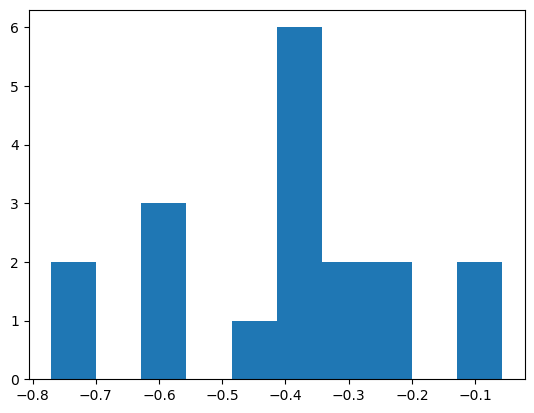

In [163]:
adsorbate_energy = -4.795631525
miller_index = 544
df_miller = df.query(f"miller_idx=={miller_index}").copy()
## remove duplicate configurations
configs_for_deduplication =  df_miller.relaxed_atoms.tolist()
idxs_to_keep = deduplicate(configs_for_deduplication, 0)
df_miller = df_miller.iloc[idxs_to_keep].copy()
# get the slab energy
slab_energy = df_slab.query(f"miller_idx=={miller_index}")["slab_energy"].values[0]
df_miller["adsorption_energy"] = df_miller["relaxed_energy_ml"]- slab_energy - adsorbate_energy*2
plt.hist(df_miller["adsorption_energy"]);

### Count the number of atoms with adsorption energy less than a threshold and normalize by the surface area

In [164]:
ads_energy_threshold = -0.8
num_atoms_covered = len(np.where(df_miller["adsorption_energy"] <= ads_energy_threshold)[0])
surface_area = np.linalg.norm(np.cross(df_miller.relaxed_atoms.values[0].cell[0], 
                                       df_miller.relaxed_atoms.values[0].cell[1]))
print(surface_area, num_atoms_covered)
num_atoms_covered/surface_area

204.16213356498452 0


0.0

In [161]:
active_site_ratio = {}
for miller_index in tqdm(np.unique(df.miller_idx)):
    try:
        df_miller = df.query(f"miller_idx=={miller_index}").copy()
        ## remove duplicate configurations
        configs_for_deduplication =  df_miller.relaxed_atoms.tolist()
        idxs_to_keep = deduplicate(configs_for_deduplication, 0)
        df_miller = df_miller.iloc[idxs_to_keep].copy()
        # get the slab energy
        slab_energy = df_slab.query(f"miller_idx=={miller_index}")["slab_energy"].values[0]
        # get the adsorption energy
        df_miller["adsorption_energy"] = df_miller["relaxed_energy_ml"]- slab_energy - adsorbate_energy*2
        ## count the number of atoms with adsorptopn energy less  than the threshold
        num_atoms_covered = len(np.where(df_miller["adsorption_energy"] <= ads_energy_threshold)[0])
        surface_area = np.linalg.norm(np.cross(df_miller.relaxed_atoms.values[0].cell[0], 
                                            df_miller.relaxed_atoms.values[0].cell[1]))
        active_site_ratio[miller_index] = num_atoms_covered/surface_area
    except:
        print(miller_index)

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 10.33it/s]

232.0
322.0
332.0


100%|██████████| 5/5 [00:00<00:00,  8.86it/s]

454.0


In [162]:
active_site_ratio

{544.0: 0.0}

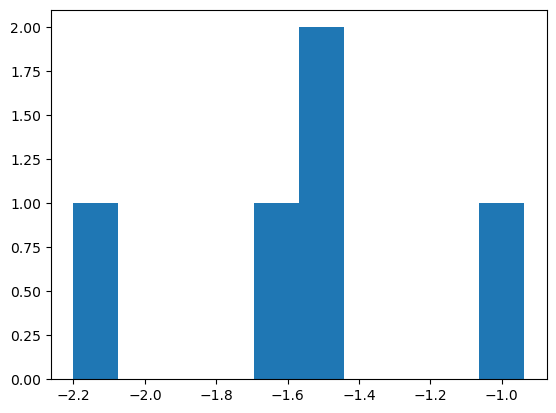

In [139]:
miller_index = 100
df_miller = df.query(f"miller_idx=={miller_index}").copy()
configs_for_deduplication =  df_miller.relaxed_atoms.tolist()
idxs_to_keep = deduplicate(configs_for_deduplication, 0)
df_miller = df_miller.iloc[idxs_to_keep].copy()
slab_energy = df_slab.query(f"miller_idx=={miller_index}")["slab_energy"].values[0]
df_miller["adsorption_energy"] = df_miller["relaxed_energy_ml"]- slab_energy - adsorbate_energy*2
plt.hist(df_miller["adsorption_energy"]);

In [140]:
num_atoms_covered = len(np.where(df_miller["adsorption_energy"] <= ads_energy_threshold)[0])
surface_area = np.linalg.norm(np.cross(df_miller.relaxed_atoms.values[0].cell[0], 
                                       df_miller.relaxed_atoms.values[0].cell[1]))
print(surface_area, num_atoms_covered)
num_atoms_covered/surface_area

108.16774824667027 5


0.046224499271241094

In [141]:
df_miller

,index,relaxation_idx,relaxed_atoms,relaxed_energy_ml,anomolous,miller_idx,placement_num,adsorption_energy
495,536,10024,"(Atom('Cu', [2.622176170349121, -0.02150559425...",-203.784851,False,100.0,24.0,-2.200617
150,164,10035,"(Atom('Cu', [2.6010055541992188, -0.0030067714...",-203.097717,False,100.0,35.0,-1.513483
168,186,10083,"(Atom('Cu', [2.597618341445923, -0.01196864526...",-203.090210,False,100.0,83.0,-1.505975
597,645,10050,"(Atom('Cu', [2.58272385597229, 0.0375844463706...",-203.229523,False,100.0,50.0,-1.645288
539,586,10085,"(Atom('Cu', [2.603386163711548, 0.000360100646...",-202.521667,False,100.0,85.0,-0.937433


In [151]:
view(df.query(f"miller_idx==100")["relaxed_atoms"].values[0], viewer='x3d')

In [145]:
view(df_miller["relaxed_atoms"].values[0], viewer='x3d')

In [144]:
view(df_miller["relaxed_atoms"].values[1], viewer='x3d')

In [146]:
view(df_miller["relaxed_atoms"].values[2], viewer='x3d')

In [147]:
view(df_miller["relaxed_atoms"].values[3], viewer='x3d')

In [148]:
view(df_miller["relaxed_atoms"].values[4], viewer='x3d')